In [ ]:
models = {
    'craft_mlt_25k.pth': 'https://drive.google.com/file/d/1DzOy8ksAXCTnYGeJ2ksSFpA2B6ceZnKW/view?usp=sharing'}

In [ ]:
for k, v in models.items():
    doc_id = v[v.find('=')+1:]
    !curl -c /tmp/cookies "https://drive.google.com/uc?export=download&id=$doc_id" > /tmp/intermezzo.html
    !curl -L -b /tmp/cookies "https://drive.google.com$(cat /tmp/intermezzo.html | grep -Po 'uc-download-link" [^>]* href="\K[^"]*' | sed 's/\&amp;/\&/g')" > $k

!ls -al *.pth

In [1]:
!python ./text_detection/test.py \
--trained_model ./text_detection/weights/craft_mlt_25k.pth \
--test_folder ./text_detection/test/

Loading weights from checkpoint (./text_detection/weights/craft_mlt_25k.pth)
elapsed time : 12.467748403549194sest/test1.jpg


In [2]:
import pandas as pd
import os
from PIL import Image

In [3]:
img = Image.open('./text_detection/test/test1.jpg','r')

In [14]:
res_img = Image.open('./text_detection/result/res_test1.jpg','r')

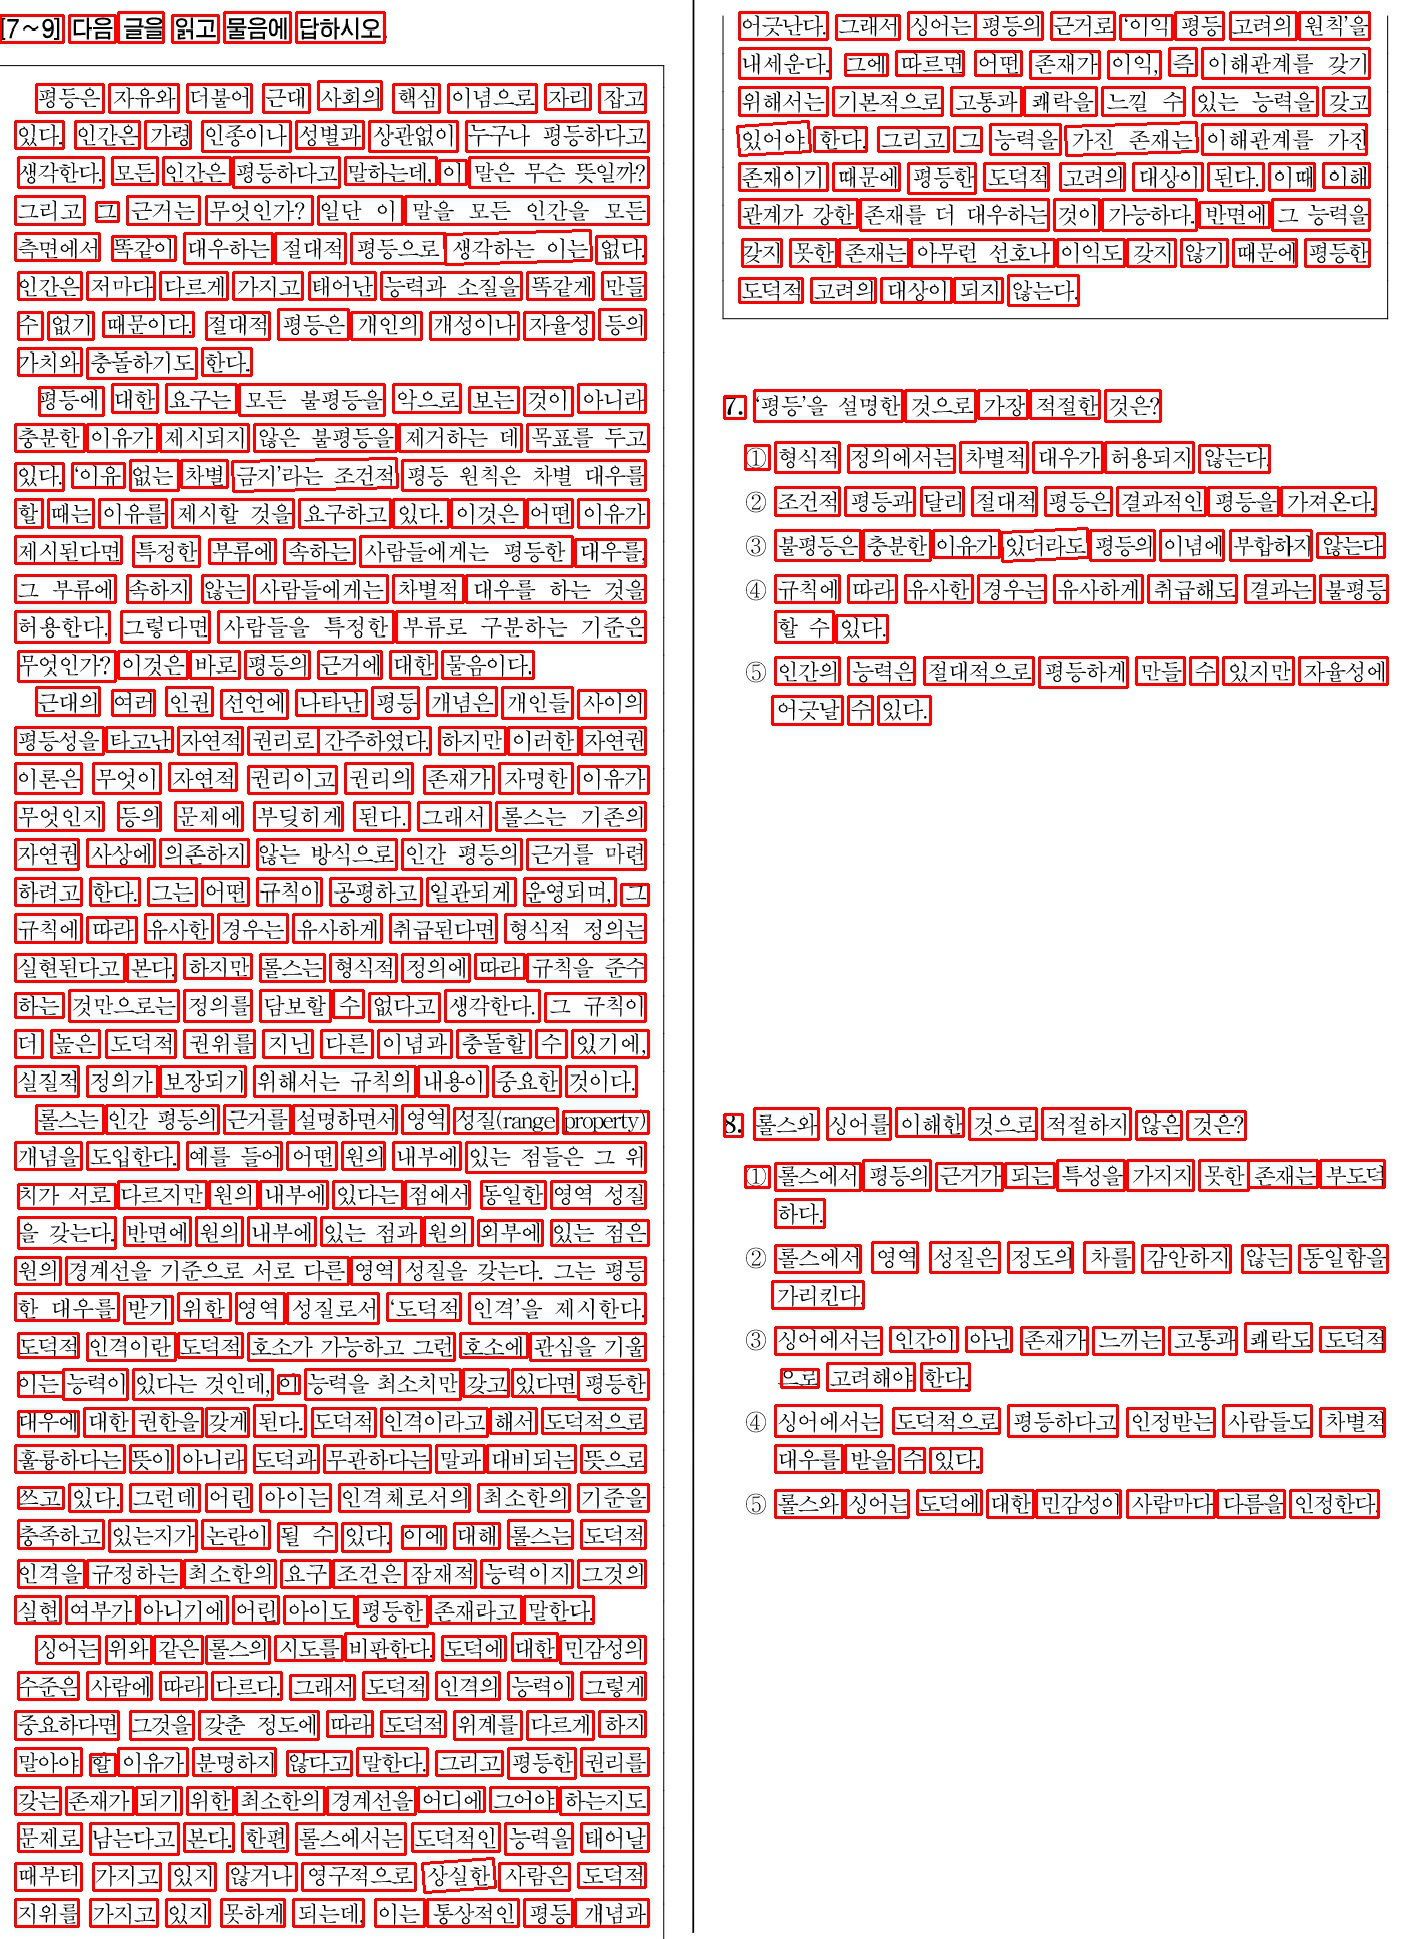

In [15]:
res_img

In [4]:
df = pd.read_csv('./text_detection/result/res_test1.txt',sep=',',names=['x1','y1','x2','y2','x3','y3','x4','y4'])

In [5]:
df['text_size'] = df['y3'] - df['y1']

In [6]:
df1 = df[df['x1']<img.size[0]/2].reset_index(drop=True)

In [7]:
df2 = df[df['x1']>=img.size[0]/2].reset_index(drop=True)

줄 나누기

In [8]:
line_list = []
text_size = df['text_size'].mean()
for d in [df1,df2]:
    start = len(line_list)
    for _ in range(len(d)):
        x1,y1,x2,y2,x3,y3,x4,y4,text_size = d.loc[_]
        box = x1,y1,x2,y2,x3,y3,x4,y4

        idx = 0
        
        if _ == 0:
            li = []
            li.append(box)
            line_list.append(li)
            
        for line in line_list[start:]:
            do_append = 'F'
            if _ ==0:
                break
            for i in line:
                if (abs(((y1 + y3) /2) - ((i[1] + i[5])/2)) < text_size):
                    line.append(box)
                    line.sort()
                    do_append = 'T'
                    break    
            if do_append == 'T':
                break
            else:
                idx += 1

        if idx == len(line_list[start:]):
            new_line = []
            new_line.append(box)
            line_list.append(new_line)
        

단락 나누기

In [9]:
before_x_point = 0
before_y_point = 0
text_structure = []
idx = 0
for line in line_list:
    if idx ==0:
        new_paragraph = []
        new_paragraph.append(line)
    
    else:
        # 단 찾기
        if (before_y_point - line[0][1]) >= 3*text_size:
            if line[0][0] - img.size[0]/2 >= 18*3:
                text_structure.append(new_paragraph)
                new_paragraph = []
                new_paragraph.append(line)
            else:
                new_paragraph.append(line)
        else:
            # 줄 바꿈
            if (line[0][1] - before_y_point) > 3*text_size:
                text_structure.append(new_paragraph)
                new_paragraph = []
                new_paragraph.append(line)
            else:
                if line[0][0] - before_x_point >= 18:
                    text_structure.append(new_paragraph)
                    new_paragraph = []
                    new_paragraph.append(line)
                else:
                    new_paragraph.append(line)
         
    before_x_point = line[0][0]
    before_y_point = line[0][1]
    idx += 1
    
    if idx == len(line_list):
        text_structure.append(new_paragraph)

단락별 줄별 이미지 저장

In [12]:
a = 0
k = 0
for paragraph in text_structure:
    path = './text_detection/result/test1_structure/'
    paragraph_path = path + 'paragraph' + str(k) + '/'
    os.mkdir(paragraph_path)
    for line in paragraph:
        line.sort()
        line_path = paragraph_path + 'line' + str(a) + '/'
        os.mkdir(line_path)
        b = 0
        for box in line:
            x1,y1,x2,y2,x3,y3,x4,y4 = box
            image = img.crop((x1,y1,x3,y3))
            image.save(line_path + str(b) +'.jpg')
            b += 1
        a += 1
    k += 1